# Deasang 생산량 예측 (Capa 예측)

대상 데이터를 활용해 아래와 같은 결과 값을 구현하였습니다.


**목적**
1. 신규 아이템에 대한 증감 예측
2. 월평균으로 2020년도의 QTY 예측


**Input 정보**
- 데이터 셋 파일명: DAESANG_DATA_prepared.csv
- 설정 옵션 파일명: input_시계열모델_설정옵션.csv
- 분석 조건 값 파일명: input_시계열모델_조건설정값.csv
- 데이터 유형 파일명: input_시계열모델_데이터유형.csv

**Output 정보**
- 예측 결과
- 예측 모델 정보
- 예측 모델 값
- 변수 중요도



※ 자세한 Input정보는 같은 폴더에 있는 Readme를 참고 해주세요.

## 1. 개요


###  시나리오 1.유사제품 예측 (차분 & 랜덤포레스트 분석)
- 예측 모델의 입출력 값
  - Input(x)은 신규 아이템에 대한 속성(이전에 **_없던_** 속성 값)
  - Output(y)는 신규 아이템에 대한 QTY값(예측대상)의 증감
  
  시나리오 2.1 월간예측 (차분 & Auto_ML 사용)
   - 계절성 확인 목적
 
### 시나리오 2. 월평균 예측 (선형분석)
- 예측 모델의 입출력 값
  - Input(x)은 신규 아이템에 대한 속성(이전에 **_있던_** 속성 값)
  - Output(y)는 기존 아이템에 대한 평균 QTY 예측값 

In [1]:
# !pip install pmdarima # have to install for Library # 처음 실행시 필요

In [2]:
# 필요 라이브러리
import csv
import pandas as pd
import numpy as np
import ast

from matplotlib import pyplot as plt
from pandas import DataFrame
from pandas import read_csv

from sklearn.ensemble import RandomForestRegressor# Instantiate model with 1000 decision trees
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
import statsmodels.api as sm
import seaborn as sns

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.ensemble import ExtraTreesClassifier

In [21]:
# 구현 함수
def get_data_type(data_type_file):
    data_type_df = pd.read_csv(data_type_file,encoding='cp949')
    
    x_val = data_type_df.loc[data_type_df['Role']=='x', 'col_name'].tolist() # x변수 다중리스트형태
    y_val = data_type_df.loc[data_type_df['Role']=='y', 'col_name'].tolist()[0] # y변수는 단일
    predic_period = data_type_df.loc[data_type_df['예측주기']=='P', 'col_name'].tolist()[0] # y변수는 단일
    
    dummy_list = data_type_df.loc[data_type_df['col_info']=='STR', 'col_name'].tolist()# y변수는 단일
    
    item_col = data_type_df.loc[data_type_df['col_info']=='STR_KEY', 'col_name'].tolist()# y변수는 단일
    
    return x_val, y_val, dummy_list,item_col[0],predic_period

def get_variables(setting_file_name, condition_file_name):
    """
    Input: setting_file_name(모델설정값파일이름), condition_file_name(조건설정값파일이름)
    
    Input 설정 파일에서 지정된 컬럼 명으로 설정 값 및 조건 값들을 불러옴
    
    return: Date지정 컬럼명, 타겟 컬럼명, 주기 값, 조건 값(리스트 )
    """
    setting_df = pd.read_csv(setting_file_name,encoding='cp949')
    date_col_name = setting_df.at[0, 'Date_col'] 
    target_name = setting_df.at[0, 'Target'] 
    p = setting_df.at[0, 'Period'] 
    
    condition_df = pd.read_csv(condition_file_name,encoding='cp949')
    keys = condition_df['condition_col_name'].tolist()
    values = condition_df['condition'].tolist()
    
    condition_list = get_conditions(keys,values)
    
    return date_col_name, target_name, p, condition_list

def change_col_to_int (df, col_name_change_to_int): 
    # 데이터 유형 정보가 담긴 row1이 string이라 계산값 (타겟) int전환 필요
    df[col_name_change_to_int] = df[col_name_change_to_int].astype('int32')

def get_conditions(keys,values):
    """
    Input: keys(조건 컬럼명), values(조건)
    
    return: Dictionary 형태로 조건 컬럼명과 조건 
    """
    values = [tryeval(x) for x in values]
    values2 = [[_] for _ in values]
    conditions = dict(zip(keys, values2))
    return conditions

def tryeval(val): # change str into int in a list 
    try:
        val = ast.literal_eval(val)
    except ValueError:
        pass
    return val

def get_dataset(data_file_name,target_name):
    """
    Input: data_file_name(데이터셋 파일이름),target_name(설정값에서 불러온 타겟명)
    
    파일읽고 df에 저장, 타겟값은 int로 지정, Train dataset, TestDataset 분리
    """
    df = pd.read_csv(data_file_name, encoding='cp949') # encoding은 한국어 load 
    df = df.drop([0]) # 데이터 유형은 실제 데이터 학습에 필요하지 않음으로 드롭
    df.fillna(0, inplace=True) # RD에 있는 NAN 데이터를 0으로 바꿈 => 데이터 유형을 정수로 표현하기 위해 (데이터 셋 분리과정)
    change_col_to_int(df,target_name)
    
    # TD, RD 분리 (학습 데이터 및 실험 데이터 생성)
    train = df[df['DATA_TYPE']== 'TD']
    test = df[df['DATA_TYPE']== 'RD']
    
    return df, train, test

def get_model_var(df,Model_ver):  #모델버전 생성 
    df = df.reset_index(drop=False)
    Model_ver_list =  [Model_ver] * len(df)
    Model_ver_list = pd.DataFrame(Model_ver_list, columns =['모델 버전'])
    
    updated_df = pd.concat([Model_ver_list,df] ,axis=1)
    return updated_df

def c_columns(df):
    cols = []
    cols.append('모델')
    for i in range(len(df.columns)-1):
        col = 'c'+str(i)
        cols.append(col)
    return cols

def export_results_reg(df_model,y_pred_year,y_test,f1,f2,f3): #시계열 식 결과 export into excel
    model_results = df_model.summary()

    model_info = model_results.tables[0].as_html()
    model_info = pd.read_html(model_info, header=0, index_col=0)[0]
    
    model_result = model_results.tables[1].as_html()
    model_result = pd.read_html(model_result, header=0, index_col=0)[0] # Excel 내보내기
    
    Model_ver = model_info[y_val][0] + "_" + model_info[y_val][1] + "_"+model_info[y_val][2]
   
    model_info_df = get_model_var(model_info,Model_ver)
    model_info_df.columns = pd.MultiIndex.from_tuples(zip(c_columns(model_info_df), model_info_df.columns)) 
    
    model_result_df = get_model_var(model_result,Model_ver)
    model_result_df.columns = pd.MultiIndex.from_tuples(zip(c_columns(model_result_df), model_result_df.columns)) 
    
    prediction_df = pd.DataFrame(data=y_pred_year)
    prediction_df.columns = ['예측값']
    
    results_pred_df = get_model_var(prediction_df,Model_ver)
    results_pred_df_= results_pred_df.set_index('PART').join(y_test)
    
    outputfile(results_pred_df_,f1) # 예측값 엑셀로 내보내기
    outputfile(model_info_df,f2) # 모델 정보 엑셀로 내보내기
    outputfile(model_result_df,f3) # 모델 식 엑셀로 내보내기
    
    return model_info_df,model_result_df,Model_ver,results_pred_df_

def outputfile(result1,output_file_name): # Export result into excel 
    result1.to_csv(output_file_name,encoding='utf-8-sig')
    print("\n▼ 폴더에서",output_file_name,"파일을 확인하세요")

    
def index_match_prediction(y_pred_df):
    indexs = pd.DataFrame(y_pred_df.index.str.split('-',1).tolist(),
                                 columns = ['RD_index','TD_index'])
    y_pred_df_ = y_pred_df.reset_index(drop=True)
    result = pd.concat([indexs,y_pred_df_], axis=1)
    return result    
    
def filter_df(df, filter_values):
    """
    Input: df(데이터셋), filter_values(Dic 형태의 조건 리스트: condition_list)
    
    Filter df by matching targets for multiple columns.
    지정된 조건에 df 필터
    
    return 조건에 맞는 데이터셋 
    """
    if filter_values is None or not filter_values:
        return df
    return df[
        np.logical_and.reduce([
            df[column].isin(target_values) 
            for column, target_values in filter_values.items()
        ])
    ]

def find_similar_Item_ID(new_grouped1,item_col):
    index_list = []
    for i in range(len(new_grouped1)):
        index = new_grouped1.index[i].split('-')[1]
        index_list.append(int(index))
        
    item_list_by_index = []
    for i in index_list:
        item = df[df.index == i][item_col].values[0]
        item_list_by_index.append(item)
        
    index_list_for_Predict = []
    for i in range(len(new_grouped1)):
        index = new_grouped1.index[i].split('-')[0]
        index_list_for_Predict.append(int(index))
        
    item_list_for_Predict = []
    for i in index_list_for_Predict:
        item = df[df.index == i][item_col].values[0]
        item_list_for_Predict.append(item)
    
    return index_list,item_list_by_index,index_list_for_Predict,item_list_for_Predict


# new data (X_Predict) 와 X_Train의 차분 계산
def subtract (new_test_df,train_df):
    dff = pd.DataFrame()
    for i in range(len(new_test_df.columns)):
        for j in range(len(train_df.columns)):
            var = str(new_test_df.columns[i]) + '-' + str(train_df.columns[j])
            dff[var] = abs(new_test_df.iloc[:,i].astype('int32')-train_df.iloc[:,j].astype('int32'))
    
    temp_train_x = pd.DataFrame(data=dff)
    
    return temp_train_x.T

def get_subtract_sample(x):
    x = x.transpose()
    dff = pd.DataFrame()
    for i in range(len(x.columns)):
        for j in range(i+1,len(x.columns)):
            var = str(x.columns[i]) + '-' + str(x.columns[j])
            dff[var] = abs(x.iloc[:,i].astype('int32')-x.iloc[:,j].astype('int32'))
            
    temp_train_x = pd.DataFrame(data=dff)
    #temp_train_x_0 = temp_train_x.fillna(0)
    
    return temp_train_x.T


## 데이터 불러오기 및 데이터 준비  (공통)
#### 설정 값 파일 읽기 (사용 된 함수)
   - get_variables() : 날자 컬럼, 타겟 컬럼, 주기, 조건 리스트
   -  get_dataset()  : Train & Test 데이터 세트 준비
   - get_data_type() : x변수, y변수, 명목변수, key이름, 주기 준비

In [4]:
# Input 파일 
data_file_name = 'DAESANG_DATA_prepared.csv'
setting_file_name = 'input_시계열모델_설정옵션.csv'
data_type_file = 'input_시계열모델_데이터유형.csv'
condition_file_name = 'input_시계열모델_조건설정값.csv'

## 시나리오 1. 유사제품 예측 (차분 & 랜덤포레스트 분석)


- 2월 제품 중 상온이지만 판매 방식, 등급이 다른 4가지 제품의 QTY 예측
- 비슷한 제품 찾기 (비슷제품 1)

**가정:**   QTY를 예측하고 싶은 제품A는 기존 제품B와 특성이 비슷

**∴ _제품A_ 는 _기존 제품B_ 의 예측값이랑 비슷할 것이다**
- 시나리오 2.1 데이터 준비 및 더미화
- 시나리오 2.2 모델 실행 및 유사성 예측값 출력
- (참고1) 유사제품 순위
- (참고2) 유사제품 시계열 예측

##### 1. 데이터 준비 및 더미화
- 지정된 x와 y로 데이터셋 구성
    - TD: x_train, y_train 
    - RD: x_predic, y_pred(예측값)

In [5]:
# 실험을 위한 파라미터 
samplesize = 200
num_of_prediction = 5

In [6]:
condition_file_name = 'input_시계열모델_조건설정값3.csv'
date_col_name, target_name, p, condition_list = get_variables(setting_file_name, condition_file_name)
df, train, test = get_dataset(data_file_name,target_name)
x_val, y_val, dummy_list,item_col,predic_period = get_data_type(data_type_file) # x변수, y변수, 명목변수, key이름, 주기
dummies = [x for x in dummy_list if x in x_val] 
mon = condition_list.get(predic_period)[0]

C:\Users\Kstec\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3338: DtypeWarning: Columns (2,5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [7]:
# 더미화
try_df = pd.get_dummies(data=df[dummies])
try_df_ = pd.concat([try_df, df[[predic_period]],df[['DATA_TYPE']],df[[y_val]]],axis=1)

x_train_dummified = try_df_.loc[(try_df_[predic_period]==mon) & (try_df_['DATA_TYPE']=='TD')]
x_test_dummified = try_df_.loc[(try_df_[predic_period]==mon) & (try_df_['DATA_TYPE']=='RD')]

In [8]:
# 실험용
x_train_dummified = x_train_dummified[x_train_dummified['FEATURE_1_상온'] == 1] # 빠른 체크를 위한 상온만 필터
x_test_dummified = try_df_.loc[(try_df_[predic_period]==mon) & (try_df_['DATA_TYPE']=='RD')].head(num_of_prediction)

##### 2. 학습용 데이터셋 준비 (차분과정)

In [9]:
x_train = x_train_dummified.drop(['MONTH','DATA_TYPE'], axis=1) # drop month and data_type (QTY는 유지)

x_pred = x_test_dummified.drop(['MONTH','DATA_TYPE'], axis=1)
y_pred = x_test_dummified[[y_val]]

In [10]:
# 실험용
x_train = x_train.sample(n=samplesize)

##### 2.1 학습용 차분

**get_subtract_sample()** 로 차분된 데이터셋 생성

In [11]:
train_dummied_sub_self = get_subtract_sample(x_train)

In [12]:
train_dummied_sub_self.head() # 차분된 데이터 셋 

,FEATURE_1_냉동,FEATURE_1_냉장,FEATURE_1_상온,FEATURE_1_전분당:포장,FEATURE_2_B2B,FEATURE_2_B2C,FEATURE_2_미지정,FEATURE_4_A,FEATURE_4_B,FEATURE_4_C,FEATURE_4_O,FEATURE_4_X,FEATURE_5_0,FEATURE_5_A,FEATURE_5_B,FEATURE_5_C,QTY
80815-35783,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,105
80815-28742,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,1,14
80815-93630,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,291
80815-3925,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,10494
80815-31176,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,310


In [13]:
# 모델링을 위한 데이터 구분
x_train_dummied_sub_self = train_dummied_sub_self.drop([y_val], axis=1)
y_train_dummied_sub_self = train_dummied_sub_self[[y_val]]

##### 2.2 예측용 데이터셋 차분

**subtract()** 로 예측 데이터와 학습 데이터 차분
- x_pred 사용

In [14]:
x_predict_data_sub =subtract(x_pred.T, x_train.T)
x_predict_data_sub_ = x_predict_data_sub.drop([y_val], axis=1)

### 시나리오 1.3 모델 실행 및 유사성 예측값 출력
**RandomForestRegressor(X_Train_df,y_Train_df)** 랜덤포레스트 모델 적용

In [15]:
RF_model = RandomForestRegressor(max_depth=2, random_state=0).fit(x_train_dummied_sub_self, y_train_dummied_sub_self)
y_pred= RF_model.predict(x_predict_data_sub_)
y_pred_df = pd.DataFrame(data=y_pred)
y_pred_df.columns = ['Predicted']
y_pred_df.index = x_predict_data_sub_.index
y_pred_df_ =  index_match_prediction(y_pred_df) # 결과값
y_pred_df_ #RD_index would be smilar to TD_index, presucted by subtracted distance 

<ipython-input-15-2a6e5468c301>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RF_model = RandomForestRegressor(max_depth=2, random_state=0).fit(x_train_dummied_sub_self, y_train_dummied_sub_self)


,RD_index,TD_index,Predicted
0,38,80815,625.457383
1,38,35783,1440.199327
2,38,28742,1440.199327
3,38,93630,625.457383
4,38,3925,2477.997649
...,...,...,...
995,463,10701,1440.199327
996,463,55668,2477.997649
997,463,101734,2476.739835
998,463,126756,1440.199327


In [16]:
file_name_1 = "output_랜덤포레스트_차분_유사성결과.csv" # 유사값 엑셀로 내보내기

# 결과 엑셀로 내보내기
outputfile(y_pred_df_,file_name_1)


▼ 폴더에서 output_랜덤포레스트_차분_유사성결과.csv 파일을 확인하세요


#### (참고) 유사성 랭크 순위 

In [17]:
group_list = list(range(num_of_prediction)) # size of RD
res =  [ele for ele in group_list for i in range(samplesize)]
res1 =  pd.DataFrame(res, columns = ['Group'], index = y_pred_df.index) 
Grouped = pd.concat([res1,y_pred_df ],axis=1) 
# 제품간의 차분 거리가 가장 작은 top1 
result_top1 = Grouped.drop_duplicates().groupby('Group', group_keys=False).apply(lambda x: x.sort_values('Predicted', ascending=True)).groupby('Group').head(1)
result_top1

,Group,Predicted
38-80815,0,625.457383
268-35783,1,625.457383
333-3925,2,1440.199327
398-35783,3,625.457383
463-3925,4,1440.199327


In [18]:
# 제품간의 차분 거리가 가장 작은 top5 
result_top5 = Grouped.drop_duplicates().groupby('Group', group_keys=False).apply(lambda x: x.sort_values('Predicted', ascending=True)).groupby('Group').head(5)
result_top5 

,Group,Predicted
38-80815,0,625.457383
38-35783,0,1440.199327
38-11103,0,2476.739835
38-3925,0,2477.997649
268-35783,1,625.457383
268-80815,1,1440.199327
268-3925,1,2360.892726
268-11103,1,2362.150540
333-3925,2,1440.199327
333-32915,2,2330.401235


## 시나리오 2. 월평균 예측 (선형분석)

   > 선형 회귀식  Y= c + a1.X1 + a2.X2 + a3.X3 + a4.X4 +a5X5 +a6X6 ...

#### 아이템별 월평균 데이터 셋 생성

In [23]:
change_col_to_int(train, 'YEAR')
x_train = pd.pivot_table(train, index=item_col,values=x_val, aggfunc='first')
x_train_dumm = pd.get_dummies(data=x_train)
y_train = train[['PART','QTY']].groupby('PART').mean()

y_test = pd.pivot_table(test, index=item_col,values=x_val, aggfunc='first')

<ipython-input-21-b7196585eba6>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col_name_change_to_int] = df[col_name_change_to_int].astype('int32')


####  선형 모델실행

In [24]:
lin_reg = sm.OLS(y_train, x_train_dumm).fit()

x_predict = pd.pivot_table(test, index=item_col,values=x_val, aggfunc='first')
x_predict_dumm = pd.get_dummies(data=x_predict)

y_pred_year = lin_reg.predict(x_predict_dumm)
lin_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    QTY   R-squared:                       0.141
Model:                            OLS   Adj. R-squared:                  0.139
Method:                 Least Squares   F-statistic:                     68.16
Date:                Tue, 30 Mar 2021   Prob (F-statistic):          2.77e-129
Time:                        16:59:20   Log-Likelihood:                -39303.
No. Observations:                4169   AIC:                         7.863e+04
Df Residuals:                    4158   BIC:                         7.870e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
FEATURE_1_냉동       -88.0447    591.491     -0.149      0.882   -1247.683    1071.594
FEATURE_1_냉장       465.8940    586.112      0.795      0.427    -683.199    1614.987
FEATURE_1_상온       518.9850    585.637      0.886      0.376    -629.176    1667.146
FEATURE_1_전분당:포장   222.9124   2431.908      0.092      0.927   -4544.928    4990.753
FEATURE_2_B2B      750.6791    232.771      3.225      0.001     294.323    1207.035
FEATURE_2_B2C       95.3954    227.828      0.419      0.675    -351.269     542.059
FEATURE_2_미지정      273.6723    254.747      1.074      0.283    -225.769     773.113
FEATURE_4_A       1432.9913    254.931      5.621      0.000     933.189    1932.793
FEATURE_4_B       -393.1246    208.031     -1.890      0.059    -800.977      14.728
FEATURE_4_C       -766.1944    174.232     -4.398      0.000   -1107.781    -424.607
FEATURE_4_O        394.4396    284.527      1.386      0.166    -163.385     952.264
FEATURE_4_X        451.6349    239.344      1.887      0.059     -17.608     920.878
FEATURE_5_0        273.6723    254.747      1.074      0.283    -225.769     773.113
FEATURE_5_A       2190.5983    174.018     12.588      0.000    1849.429    2531.767
FEATURE_5_B       -368.7544    169.602     -2.174      0.030    -701.264     -36.245
FEATURE_5_C       -975.7695    162.082     -6.020      0.000   -1293.536    -658.003
==============================================================================
Omnibus:                     9067.766   Durbin-Watson:                   1.912
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         67196730.392
Skew:                          19.180   Prob(JB):                         0.00
Kurtosis:                     623.778   Cond. No.                     2.50e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.25e-33. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [25]:
file_name_1 = "output_월평균_선형_예측.csv" # 예측값 엑셀로 내보내기
file_name_2 = "output_월평균_선형_예측모델_정보.csv"     # 모델 정보 엑셀로 내보내기
file_name_3 = "output_월평균_선형_예델모델_결과.csv"     # 모델 식 엑셀로 내보내기
model_info_df,model_result_df,Model_ver,results_pred_df = export_results_reg(lin_reg,y_pred_year,y_test,file_name_1,file_name_2,file_name_3)


▼ 폴더에서 output_월평균_선형_예측.csv 파일을 확인하세요

▼ 폴더에서 output_월평균_선형_예측모델_정보.csv 파일을 확인하세요

▼ 폴더에서 output_월평균_선형_예델모델_결과.csv 파일을 확인하세요


### (참고: 중요도 및 상관분석)

In [26]:
train_= x_train_dumm.join(y_train)

#### Univariate Selection : 통계 테스트를 통해 변수들 간의 관계 이해 

In [27]:

# apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(train_.iloc[:,:-1],train_.iloc[:,0])
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(train_.iloc[:,:-1].columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Features','Score']  #naming the dataframe columns
featureScores_df = featureScores.sort_values(by=['Score'], ascending=False)
featureScores_df 

,Features,Score
0,FEATURE_1_냉동,3531.000000
2,FEATURE_1_상온,359.021807
1,FEATURE_1_냉장,278.797508
4,FEATURE_2_B2B,127.587346
5,FEATURE_2_B2C,63.206581
15,FEATURE_5_C,51.561413
13,FEATURE_5_A,30.795860
6,FEATURE_2_미지정,18.221917
12,FEATURE_5_0,18.221917
10,FEATURE_4_O,11.129393


#### Feature importance : 변수 중요도 확인

C:\Users\Kstec\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 45257 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Kstec\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 46041 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Kstec\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 49345 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Kstec\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 50728 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Kstec\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 51109 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Kstec\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 48120 missing from c

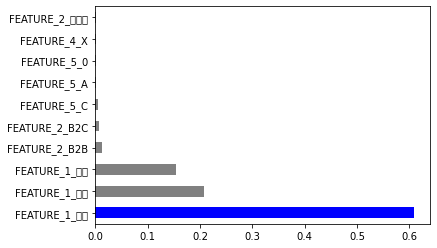

In [28]:
model = ExtraTreesClassifier()
fit = model.fit(train_.iloc[:,:-1],train_.iloc[:,0])
#print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=train_.iloc[:,:-1].columns)
clrs = ['grey' if (x < max(model.feature_importances_)) else 'blue' for x in model.feature_importances_ ]
feat_importances.nlargest(10).plot(kind='barh',color=clrs)
plt.show()

In [29]:
feature_importances_df = pd.DataFrame(model.feature_importances_, index=train_.iloc[:,:-1].columns)
feature_importances_df.columns = ['Score']
feature_importances_df

,Score
FEATURE_1_냉동,0.608953
FEATURE_1_냉장,0.154019
FEATURE_1_상온,0.207630
FEATURE_1_전분당:포장,0.000275
FEATURE_2_B2B,0.012222
FEATURE_2_B2C,0.006347
FEATURE_2_미지정,0.000470
FEATURE_4_A,0.000025
FEATURE_4_B,0.000274
FEATURE_4_C,0.000030


#### x 변수들의 상관분석

C:\Users\Kstec\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 51204 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Kstec\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 48516 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Kstec\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 45817 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Kstec\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 54252 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Kstec\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 51204 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\Kstec\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 48516 missing from cur

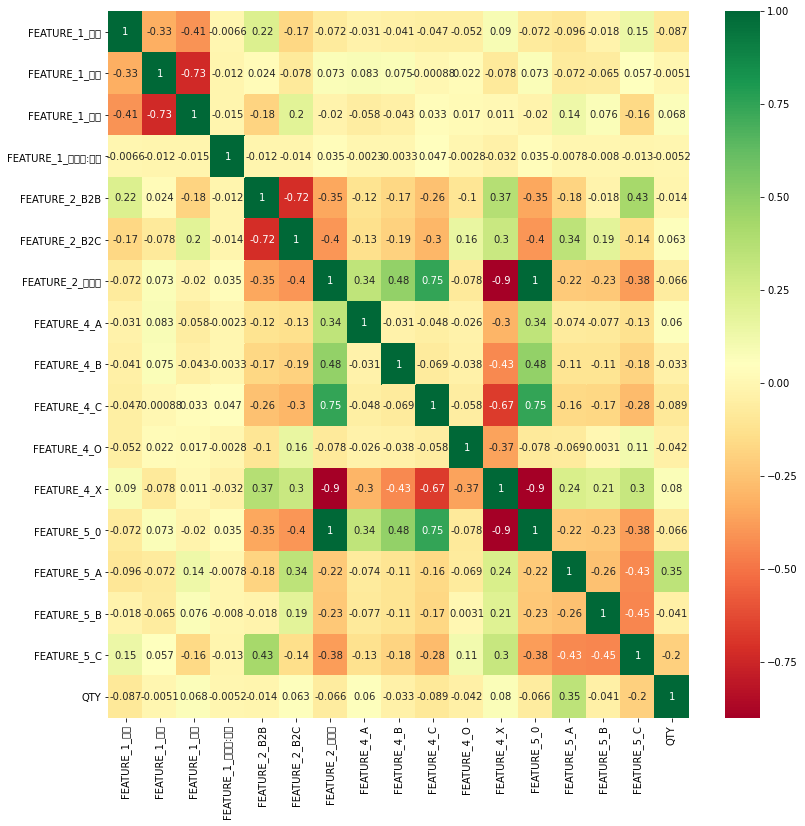

In [30]:
corrmat = train_.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(13,13))
#plot heat map
g=sns.heatmap(train_[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [31]:
train_.corr()

,FEATURE_1_냉동,FEATURE_1_냉장,FEATURE_1_상온,FEATURE_1_전분당:포장,FEATURE_2_B2B,FEATURE_2_B2C,FEATURE_2_미지정,FEATURE_4_A,FEATURE_4_B,FEATURE_4_C,FEATURE_4_O,FEATURE_4_X,FEATURE_5_0,FEATURE_5_A,FEATURE_5_B,FEATURE_5_C,QTY
FEATURE_1_냉동,1.000000,-0.325835,-0.405633,-0.006584,0.223815,-0.165991,-0.072185,-0.030515,-0.040733,-0.046903,-0.052480,0.090394,-0.072185,-0.096224,-0.017906,0.146666,-0.087352
FEATURE_1_냉장,-0.325835,1.000000,-0.731488,-0.011873,0.024126,-0.077855,0.073340,0.082694,0.075358,-0.000883,0.021960,-0.078103,0.073340,-0.071745,-0.065002,0.057442,-0.005116
FEATURE_1_상온,-0.405633,-0.731488,1.000000,-0.014781,-0.184273,0.195350,-0.019962,-0.057875,-0.043388,0.033196,0.016685,0.011330,-0.019962,0.138961,0.075995,-0.160839,0.068073
FEATURE_1_전분당:포장,-0.006584,-0.011873,-0.014781,1.000000,-0.012361,-0.014004,0.035335,-0.002288,-0.003281,0.047285,-0.002757,-0.031786,0.035335,-0.007798,-0.008024,-0.013318,-0.005216
FEATURE_2_B2B,0.223815,0.024126,-0.184273,-0.012361,1.000000,-0.721464,-0.349823,-0.117863,-0.169025,-0.261408,-0.104952,0.372629,-0.349823,-0.184942,-0.018254,0.425545,-0.014164
FEATURE_2_B2C,-0.165991,-0.077855,0.195350,-0.014004,-0.721464,1.000000,-0.396315,-0.133527,-0.191489,-0.296150,0.160524,0.299742,-0.396315,0.344376,0.185734,-0.138457,0.062517
FEATURE_2_미지정,-0.072185,0.073340,-0.019962,0.035335,-0.349823,-0.396315,1.000000,0.336921,0.483174,0.747259,-0.078018,-0.899585,1.000000,-0.220693,-0.227076,-0.376907,-0.065799
FEATURE_4_A,-0.030515,0.082694,-0.057875,-0.002288,-0.117863,-0.133527,0.336921,1.000000,-0.031283,-0.048381,-0.026286,-0.303089,0.336921,-0.074356,-0.076507,-0.126988,0.060170
FEATURE_4_B,-0.040733,0.075358,-0.043388,-0.003281,-0.169025,-0.191489,0.483174,-0.031283,1.000000,-0.069382,-0.037696,-0.434656,0.483174,-0.106633,-0.109717,-0.182112,-0.032832
FEATURE_4_C,-0.046903,-0.000883,0.033196,0.047285,-0.261408,-0.296150,0.747259,-0.048381,-0.069382,1.000000,-0.058300,-0.672224,0.747259,-0.164915,-0.169685,-0.281648,-0.088687
